In [4]:
import os
os.getcwd()

'/content'

In [5]:
os.chdir('/content/drive/MyDrive/dino/v4_0623')

In [6]:
import torch
from torch import nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms as pth_transforms

import numpy as np

import utils
import vision_transformer as vits

import scprep
from sklearn.manifold import TSNE
import pandas as pd

In [7]:
def extract_feature_pipeline(args):
    # ============ preparing data ... ============
    transform = pth_transforms.Compose([
        pth_transforms.Grayscale(),                                
        pth_transforms.ToTensor(),
        pth_transforms.Lambda(lambda x: torch.flatten(x)),
    ])
    dataset_train = ReturnIndexDataset(os.path.join(args.data_path, "train"), transform=transform)
    dataset_val = ReturnIndexDataset(os.path.join(args.data_path, "val"), transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset_train, shuffle=False)
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        sampler=sampler,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    print(f"Data loaded with {len(dataset_train)} train and {len(dataset_val)} val imgs.")

    # ============ building network ... ============
    model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
    print(f"Model {args.arch} {args.patch_size}x{args.patch_size} built.")
    model.cuda()
    utils.load_pretrained_weights(model, args.pretrained_weights, args.checkpoint_key, args.arch, args.patch_size)
    model.eval()

    # ============ extract features ... ============
    print("Extracting features for train set...")
    train_features = extract_features(model, data_loader_train)
    print("Extracting features for val set...")
    test_features = extract_features(model, data_loader_val)

    if utils.get_rank() == 0:
        train_features = nn.functional.normalize(train_features, dim=1, p=2)
        test_features = nn.functional.normalize(test_features, dim=1, p=2)

    train_labels = torch.tensor([s[-1] for s in dataset_train.samples]).long()
    test_labels = torch.tensor([s[-1] for s in dataset_val.samples]).long()
    # save features and labels
    if args.dump_features and dist.get_rank() == 0:
        torch.save(train_features.cpu(), os.path.join(args.dump_features, "trainfeat.pth"))
        torch.save(test_features.cpu(), os.path.join(args.dump_features, "testfeat.pth"))
        torch.save(train_labels.cpu(), os.path.join(args.dump_features, "trainlabels.pth"))
        torch.save(test_labels.cpu(), os.path.join(args.dump_features, "testlabels.pth"))
    return train_features, test_features, train_labels, test_labels


In [8]:
@torch.no_grad()
def extract_features(model, data_loader):
    metric_logger = utils.MetricLogger(delimiter="  ")
    features = None
    for samples, index in metric_logger.log_every(data_loader, 10):
        samples = samples.cuda(non_blocking=True)
        index = index.cuda(non_blocking=True)
        feats = model(samples).clone()

        # init storage feature matrix
        if dist.get_rank() == 0 and features is None:
            features = torch.zeros(len(data_loader.dataset), feats.shape[-1])
            if args.use_cuda:
                features = features.cuda(non_blocking=True)
            print(f"Storing features into tensor of shape {features.shape}")

        # get indexes from all processes
        y_all = torch.empty(dist.get_world_size(), index.size(0), dtype=index.dtype, device=index.device)
        y_l = list(y_all.unbind(0))
        y_all_reduce = torch.distributed.all_gather(y_l, index, async_op=True)
        y_all_reduce.wait()
        index_all = torch.cat(y_l)

        # share features between processes
        feats_all = torch.empty(
            dist.get_world_size(),
            feats.size(0),
            feats.size(1),
            dtype=feats.dtype,
            device=feats.device,
        )
        output_l = list(feats_all.unbind(0))
        output_all_reduce = torch.distributed.all_gather(output_l, feats, async_op=True)
        output_all_reduce.wait()

        # update storage feature matrix
        if dist.get_rank() == 0:
            if args.use_cuda:
                features.index_copy_(0, index_all, torch.cat(output_l))
            else:
                features.index_copy_(0, index_all.cpu(), torch.cat(output_l).cpu())
    return features

In [9]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=1000):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).cuda()
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        #print("features: ",features.shape)
        #print("train_features: ",train_features.shape)
        similarity = torch.mm(features, train_features)
        #print("similarity: ", similarity.shape)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, 5).sum().item()
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5

In [10]:
class ReturnIndexDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
        return img, idx

In [12]:
utils.init_distributed_mode(args)
print("git:\n  {}\n".format(utils.get_sha()))
print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
cudnn.benchmark = True

Will run the code on one GPU.
| distributed init (rank 0): env://
git:
  sha: 94175993abde84179449d79e22eab7ea28dec14b, status: has uncommited changes, branch: main

arch: vit_tiny
batch_size_per_gpu: 128
checkpoint_key: teacher
data_path: ../tiny-kNN-Fashion-MNIST
dist_url: env://
dump_features: None
gpu: 0
load_features: None
local_rank: 0
nb_knn: [10, 20, 100, 200]
num_workers: 10
patch_size: 4
pretrained_weights: ./v4_result_10000/checkpoint0000.pth
rank: 0
temperature: 0.07
use_cuda: True
world_size: 1


In [36]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0000.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0000.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:21    time: 1.325774  data: 1.195420  max mem: 704
  [ 10/469]  eta: 0:01:41    time: 0.221859  data: 0.159188  max mem: 704
  [ 20/469]  eta: 0:01:14    time: 0.106884  data: 0.051750  max mem: 704
  [ 30/469]  eta: 0:01:05    time: 0.107673  data: 0.052021  max mem: 704
  [ 40/469]  eta: 0:00:58    time: 0.107348  data: 0.051639  max mem: 704
  [ 50/469]  eta: 0:00:55    time: 0.109260  data: 0.052382  max mem: 704
  [ 60/46

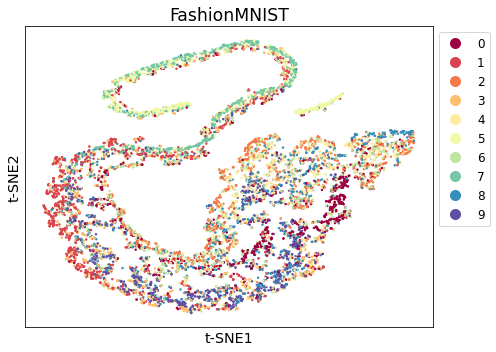

In [37]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [38]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0005.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0005.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:51    time: 1.516833  data: 1.382161  max mem: 704
  [ 10/469]  eta: 0:01:46    time: 0.232601  data: 0.168805  max mem: 704
  [ 20/469]  eta: 0:01:17    time: 0.105518  data: 0.046843  max mem: 704
  [ 30/469]  eta: 0:01:06    time: 0.106273  data: 0.045059  max mem: 704
  [ 40/469]  eta: 0:01:00    time: 0.106526  data: 0.045674  max mem: 704
  [ 50/469]  eta: 0:00:55    time: 0.104315  data: 0.043465  max mem: 704
  [ 60/46

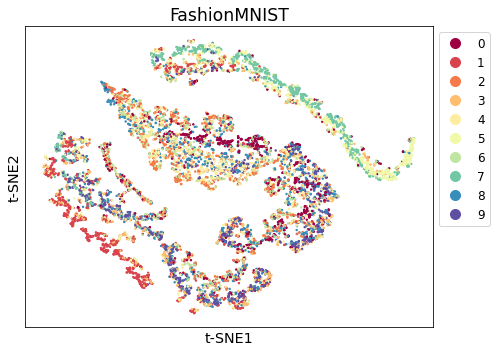

In [39]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [53]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0010.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0010.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:36    time: 1.357253  data: 1.202059  max mem: 710
  [ 10/469]  eta: 0:01:37    time: 0.212885  data: 0.147530  max mem: 710
  [ 20/469]  eta: 0:01:11    time: 0.100055  data: 0.044029  max mem: 710
  [ 30/469]  eta: 0:01:03    time: 0.106348  data: 0.054791  max mem: 722
  [ 40/469]  eta: 0:00:57    time: 0.107725  data: 0.059400  max mem: 722
  [ 50/469]  eta: 0:00:54    time: 0.105861  data: 0.058694  max mem: 722
  [ 60/46

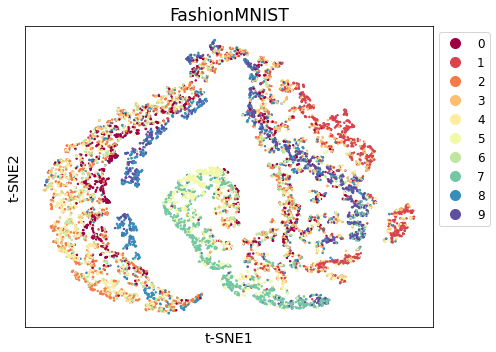

In [54]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [55]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0015.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0015.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:08:32    time: 1.093247  data: 0.967273  max mem: 785
  [ 10/469]  eta: 0:01:33    time: 0.204146  data: 0.141248  max mem: 785
  [ 20/469]  eta: 0:01:10    time: 0.110648  data: 0.054873  max mem: 785
  [ 30/469]  eta: 0:01:02    time: 0.110051  data: 0.055308  max mem: 785
  [ 40/469]  eta: 0:00:57    time: 0.111016  data: 0.056126  max mem: 785
  [ 50/469]  eta: 0:00:54    time: 0.111459  data: 0.055763  max mem: 785
  [ 60/46

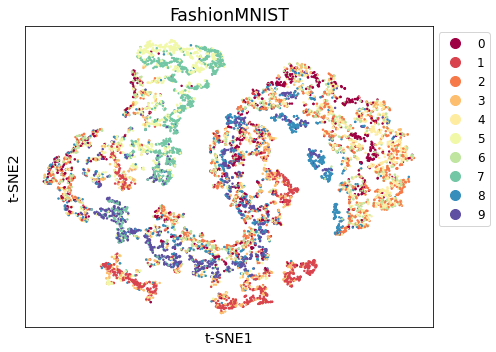

In [56]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [57]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0020.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0020.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:15    time: 1.439242  data: 1.306567  max mem: 785
  [ 10/469]  eta: 0:01:44    time: 0.228327  data: 0.165781  max mem: 785
  [ 20/469]  eta: 0:01:16    time: 0.107446  data: 0.047818  max mem: 785
  [ 30/469]  eta: 0:01:07    time: 0.113433  data: 0.049595  max mem: 785
  [ 40/469]  eta: 0:01:02    time: 0.118393  data: 0.054525  max mem: 785
  [ 50/469]  eta: 0:00:58    time: 0.117362  data: 0.052829  max mem: 785
  [ 60/46

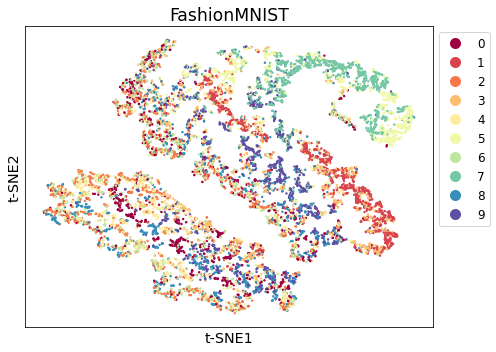

In [58]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [59]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0025.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0025.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:36    time: 1.358179  data: 1.227029  max mem: 785
  [ 10/469]  eta: 0:01:41    time: 0.222047  data: 0.160206  max mem: 785
  [ 20/469]  eta: 0:01:16    time: 0.111434  data: 0.059953  max mem: 785
  [ 30/469]  eta: 0:01:05    time: 0.109438  data: 0.060299  max mem: 785
  [ 40/469]  eta: 0:01:00    time: 0.111132  data: 0.061851  max mem: 785
  [ 50/469]  eta: 0:00:56    time: 0.111506  data: 0.062260  max mem: 785
  [ 60/46

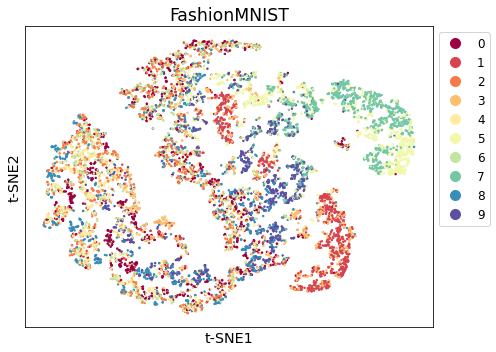

In [60]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [61]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0030.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0030.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:48    time: 1.382224  data: 1.248678  max mem: 796
  [ 10/469]  eta: 0:01:40    time: 0.218096  data: 0.155828  max mem: 796
  [ 20/469]  eta: 0:01:15    time: 0.106736  data: 0.052649  max mem: 796
  [ 30/469]  eta: 0:01:04    time: 0.107319  data: 0.052591  max mem: 796
  [ 40/469]  eta: 0:00:59    time: 0.108323  data: 0.053408  max mem: 796
  [ 50/469]  eta: 0:00:55    time: 0.110065  data: 0.056048  max mem: 796
  [ 60/46

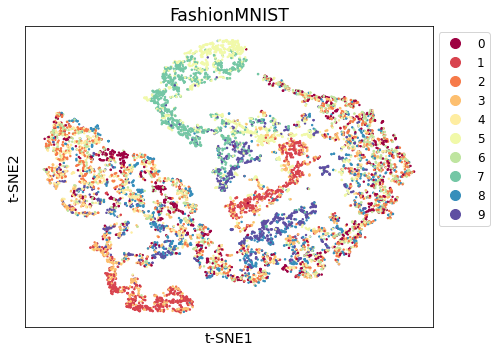

In [62]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [63]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0035.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0035.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:09:26    time: 1.208095  data: 1.070425  max mem: 796
  [ 10/469]  eta: 0:01:36    time: 0.209351  data: 0.145971  max mem: 796
  [ 20/469]  eta: 0:01:12    time: 0.109507  data: 0.056698  max mem: 796
  [ 30/469]  eta: 0:01:03    time: 0.110352  data: 0.059174  max mem: 796
  [ 40/469]  eta: 0:00:58    time: 0.110570  data: 0.057844  max mem: 796
  [ 50/469]  eta: 0:00:54    time: 0.107659  data: 0.056694  max mem: 796
  [ 60/46

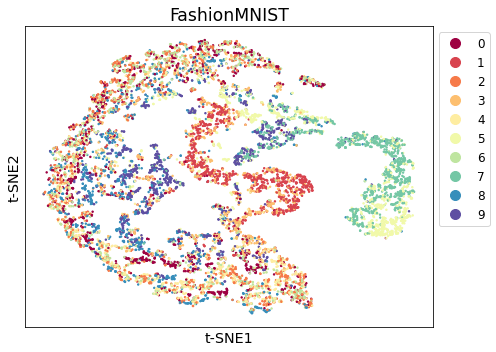

In [64]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [65]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0040.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:59    time: 1.407165  data: 1.265549  max mem: 796
  [ 10/469]  eta: 0:01:37    time: 0.213449  data: 0.150702  max mem: 796
  [ 20/469]  eta: 0:01:13    time: 0.101001  data: 0.044636  max mem: 796
  [ 30/469]  eta: 0:01:04    time: 0.109597  data: 0.052377  max mem: 796
  [ 40/469]  eta: 0:00:59    time: 0.111260  data: 0.054088  max mem: 796
  [ 50/469]  eta: 0:00:54    time: 0.107183  data: 0.048869  max mem: 796
  [ 60/46

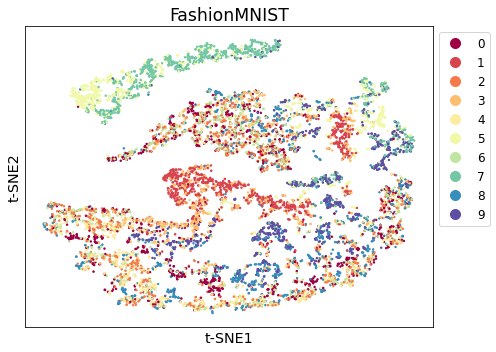

In [66]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [91]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0045.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key teacher in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0045.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:18    time: 1.445802  data: 1.318371  max mem: 796
  [ 10/469]  eta: 0:01:41    time: 0.221178  data: 0.159318  max mem: 796
  [ 20/469]  eta: 0:01:17    time: 0.109021  data: 0.054499  max mem: 796
  [ 30/469]  eta: 0:01:06    time: 0.113611  data: 0.060300  max mem: 796
  [ 40/469]  eta: 0:01:00    time: 0.108462  data: 0.057963  max mem: 796
  [ 50/469]  eta: 0:00:57    time: 0.112775  data: 0.066255  max mem: 796
  [ 60/46

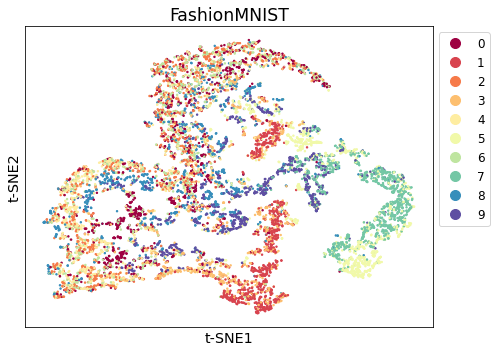

In [92]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [ ]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0050.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "teacher", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

In [69]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0000.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0000.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:02    time: 1.413477  data: 1.280908  max mem: 796
  [ 10/469]  eta: 0:01:42    time: 0.223251  data: 0.160971  max mem: 796
  [ 20/469]  eta: 0:01:16    time: 0.108004  data: 0.051867  max mem: 796
  [ 30/469]  eta: 0:01:07    time: 0.114255  data: 0.056530  max mem: 796
  [ 40/469]  eta: 0:01:00    time: 0.110526  data: 0.052052  max mem: 796
  [ 50/469]  eta: 0:00:56    time: 0.107555  data: 0.047460  max mem: 796
  [ 60/46

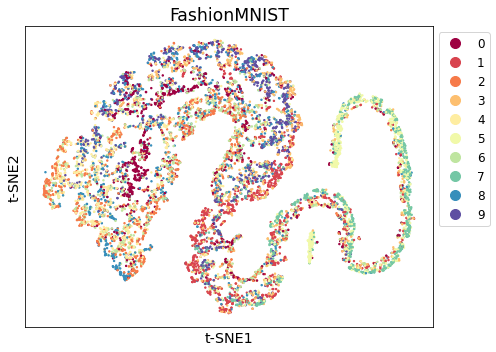

In [70]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [71]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0005.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0005.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:05    time: 1.418399  data: 1.276848  max mem: 796
  [ 10/469]  eta: 0:01:38    time: 0.213956  data: 0.151097  max mem: 796
  [ 20/469]  eta: 0:01:13    time: 0.100799  data: 0.045169  max mem: 796
  [ 30/469]  eta: 0:01:04    time: 0.111028  data: 0.054626  max mem: 796
  [ 40/469]  eta: 0:01:00    time: 0.116225  data: 0.060639  max mem: 796
  [ 50/469]  eta: 0:00:56    time: 0.116926  data: 0.060184  max mem: 796
  [ 60/46

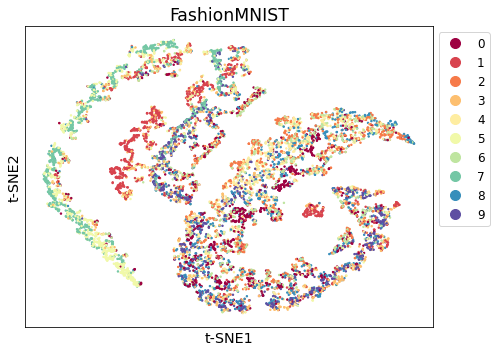

In [72]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [73]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0010.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0010.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:42    time: 1.370508  data: 1.241571  max mem: 796
  [ 10/469]  eta: 0:01:41    time: 0.221722  data: 0.158459  max mem: 796
  [ 20/469]  eta: 0:01:14    time: 0.105848  data: 0.046468  max mem: 796
  [ 30/469]  eta: 0:01:05    time: 0.110132  data: 0.047648  max mem: 796
  [ 40/469]  eta: 0:01:00    time: 0.114161  data: 0.051426  max mem: 796
  [ 50/469]  eta: 0:00:56    time: 0.110535  data: 0.047410  max mem: 796
  [ 60/46

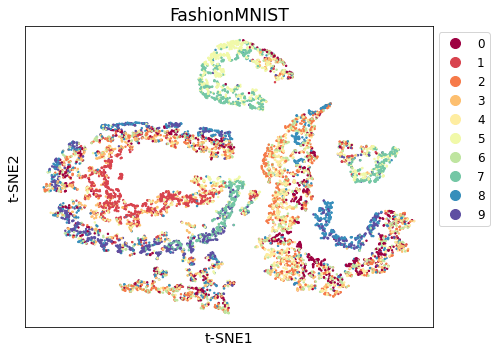

In [74]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [75]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0015.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0015.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:30    time: 1.471902  data: 1.340723  max mem: 796
  [ 10/469]  eta: 0:01:47    time: 0.233291  data: 0.171114  max mem: 796
  [ 20/469]  eta: 0:01:17    time: 0.106568  data: 0.047100  max mem: 796
  [ 30/469]  eta: 0:01:06    time: 0.105303  data: 0.043164  max mem: 796
  [ 40/469]  eta: 0:01:00    time: 0.107378  data: 0.049262  max mem: 796
  [ 50/469]  eta: 0:00:56    time: 0.111547  data: 0.056622  max mem: 796
  [ 60/46

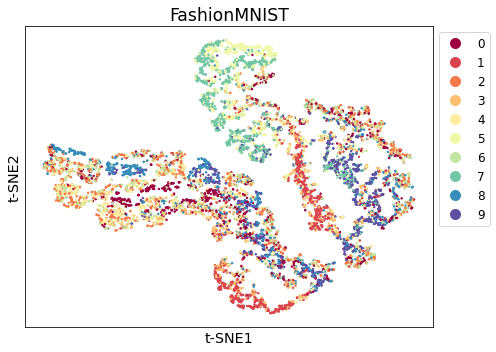

In [76]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [77]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0020.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0020.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:55    time: 1.396683  data: 1.265594  max mem: 796
  [ 10/469]  eta: 0:01:42    time: 0.224162  data: 0.162017  max mem: 796
  [ 20/469]  eta: 0:01:16    time: 0.109914  data: 0.053867  max mem: 796
  [ 30/469]  eta: 0:01:06    time: 0.112687  data: 0.053635  max mem: 796
  [ 40/469]  eta: 0:01:01    time: 0.112745  data: 0.051241  max mem: 796
  [ 50/469]  eta: 0:00:57    time: 0.113606  data: 0.052635  max mem: 796
  [ 60/46

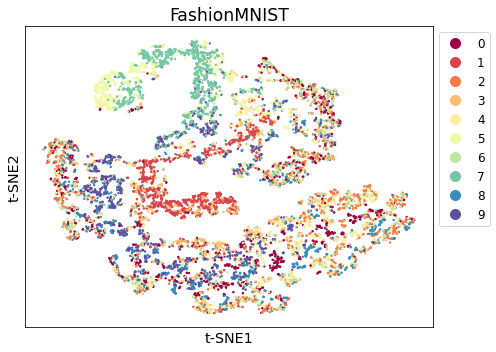

In [78]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [79]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0025.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0025.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:12    time: 1.433705  data: 1.301909  max mem: 796
  [ 10/469]  eta: 0:01:41    time: 0.221685  data: 0.159322  max mem: 796
  [ 20/469]  eta: 0:01:15    time: 0.104097  data: 0.045387  max mem: 796
  [ 30/469]  eta: 0:01:05    time: 0.109071  data: 0.047735  max mem: 796
  [ 40/469]  eta: 0:00:59    time: 0.109188  data: 0.049563  max mem: 796
  [ 50/469]  eta: 0:00:55    time: 0.106153  data: 0.047412  max mem: 796
  [ 60/46

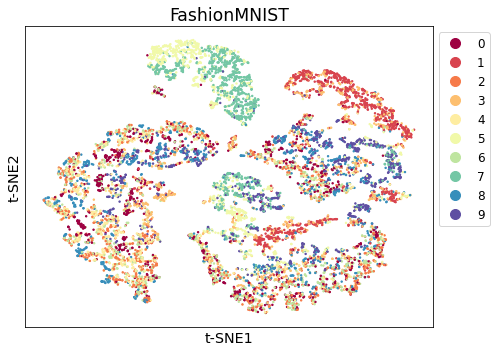

In [80]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [81]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0030.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0030.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:42    time: 1.370883  data: 1.225941  max mem: 796
  [ 10/469]  eta: 0:01:39    time: 0.216090  data: 0.153053  max mem: 796
  [ 20/469]  eta: 0:01:15    time: 0.107171  data: 0.052354  max mem: 796
  [ 30/469]  eta: 0:01:05    time: 0.112887  data: 0.056161  max mem: 796
  [ 40/469]  eta: 0:01:01    time: 0.116564  data: 0.057586  max mem: 796
  [ 50/469]  eta: 0:00:56    time: 0.109533  data: 0.050532  max mem: 796
  [ 60/46

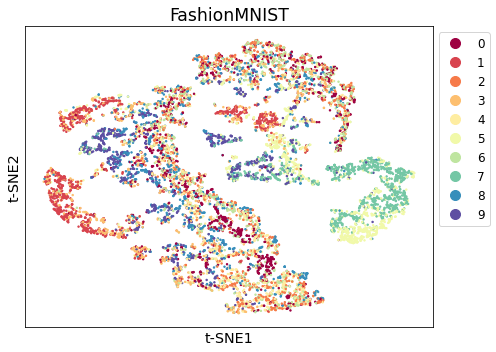

In [82]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [83]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0035.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0035.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:47    time: 1.379702  data: 1.248402  max mem: 796
  [ 10/469]  eta: 0:01:41    time: 0.221722  data: 0.159817  max mem: 796
  [ 20/469]  eta: 0:01:15    time: 0.108210  data: 0.052928  max mem: 796
  [ 30/469]  eta: 0:01:05    time: 0.108771  data: 0.053060  max mem: 796
  [ 40/469]  eta: 0:01:00    time: 0.110055  data: 0.056083  max mem: 796
  [ 50/469]  eta: 0:00:55    time: 0.106094  data: 0.052623  max mem: 796
  [ 60/46

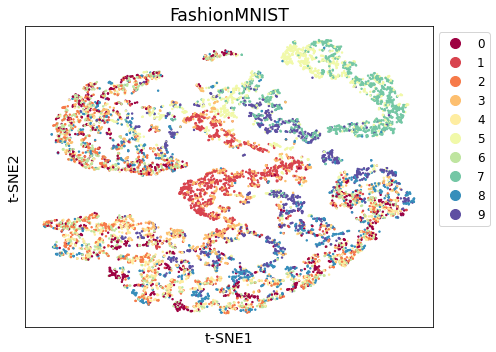

In [84]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [85]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0040.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0040.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:11:19    time: 1.448189  data: 1.322566  max mem: 796
  [ 10/469]  eta: 0:01:45    time: 0.230426  data: 0.169447  max mem: 796
  [ 20/469]  eta: 0:01:20    time: 0.114947  data: 0.054548  max mem: 796
  [ 30/469]  eta: 0:01:09    time: 0.119509  data: 0.055674  max mem: 796
  [ 40/469]  eta: 0:01:02    time: 0.112342  data: 0.050108  max mem: 796
  [ 50/469]  eta: 0:00:58    time: 0.110344  data: 0.047303  max mem: 796
  [ 60/46

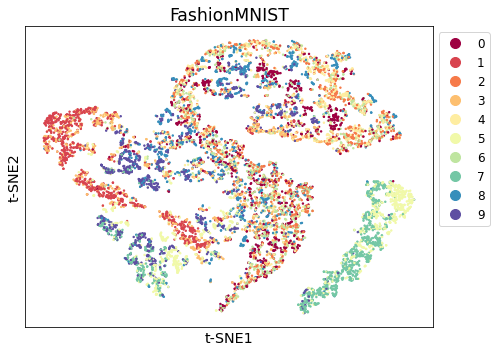

In [86]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))

In [89]:
args={"batch_size_per_gpu": 128,
      "nb_knn": [10, 20, 100, 200], 
      "temperature": 0.07,
      "pretrained_weights": './v4_result/checkpoint0045.pth',
      "use_cuda": True,
      "arch": "vit_tiny",
      "patch_size": 4, 
      "checkpoint_key": "student", 
      "dump_features": None,
      "load_features": None, 
      "num_workers": 10,
      "dist_url": "env://", 
      "local_rank": 0, 
      "data_path": '../kNN-Fashion-MNIST'}

args=AttrDict(args)

train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

if utils.get_rank() == 0:
    if args.use_cuda:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args.nb_knn:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, args.temperature)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")
dist.barrier()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 60000 train and 10000 val imgs.
num_patches:  196
Model vit_tiny 4x4 built.
Take key student in provided checkpoint dict
Pretrained weights found at ./v4_result/checkpoint0045.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting features for train set...
Storing features into tensor of shape torch.Size([60000, 192])
  [  0/469]  eta: 0:10:41    time: 1.366903  data: 1.211865  max mem: 796
  [ 10/469]  eta: 0:01:34    time: 0.205520  data: 0.145887  max mem: 796
  [ 20/469]  eta: 0:01:10    time: 0.097356  data: 0.045894  max mem: 796
  [ 30/469]  eta: 0:01:02    time: 0.105877  data: 0.054779  max mem: 796
  [ 40/469]  eta: 0:00:56    time: 0.105506  data: 0.056312  max mem: 796
  [ 50/469]  eta: 0:00:52    time: 0.103300  data: 0.055233  max mem: 796
  [ 60/46

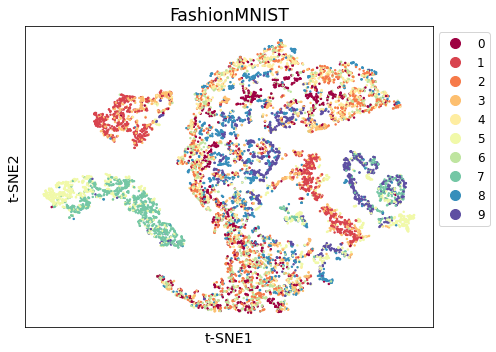

In [90]:
# ================= save output ... ========================
tr_features = train_features.cpu().numpy()
tr_labels = train_labels.cpu().numpy()
te_features = test_features.cpu().numpy()
te_labels = test_labels.cpu().numpy()
# ================= visualization ... ========================
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(te_features) # data is first moved to cpu 
data_tsne = pd.DataFrame(data_tsne, index=te_labels)
scprep.plot.scatter2d(data_tsne, c=te_labels, cmap='Spectral', # colormap
                      ticks=False, label_prefix='t-SNE', title="FashionMNIST",
                      legend_anchor=(1,1), figsize=(7,5))